#Using the Google Geocoding API to geolocate METAR data

##What is Geocoding?

- Translate physical addresses to geographic coordinates
- Access via a web services call
- Returns either XML or JSON formatted data
- [https://developers.google.com/maps/documentation/geocoding/](https://developers.google.com/maps/documentation/geocoding/)
    
##What is METAR?

- Surface observational data
- Access via a URL constructed from a web form
- Returns csv, xml, or NetCDF formatted data
- [http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr](http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr)

##Import useful libraries that (other) people have written

We need a library to understand URLs and XML documents.  If we want to make some nice plots of our data, we need a library for that, too.

In [1]:
%matplotlib inline

import urllib
import cartopy

import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

##Manage the Google API using web documentation

In [2]:
gcBaseURL='http://maps.googleapis.com/maps/api/geocode/xml?'

##Populate an address in human readable form

In [3]:
address = '3300 Mitchell Lane, Boulder, CO'
#address = 'South Pole'
#address = '1817 Pineapple Ave., Melbourne, FL'
#address = '708 N. Harvard Ave., Ventnor Heights, NJ'
print(address)

3300 Mitchell Lane, Boulder, CO


##Our address needs to look more like what the Google API expects

- No spaces in the address
- Simple string manipulation


In [4]:
address = address.replace(' ','+')
print(address)

3300+Mitchell+Lane,+Boulder,+CO


##Now let's construct the URL

- Set up the sensor component
- Assemble the URL
- Do a sanity check

In [5]:
gcParameters='address=' + address + '&sensor=false'
gcURL = gcBaseURL + gcParameters
print(gcURL)

http://maps.googleapis.com/maps/api/geocode/xml?address=3300+Mitchell+Lane,+Boulder,+CO&sensor=false


#What was that?

- Back to our libraries to decode the XML
- "Walk the DOM" to get to lat and lon
- http://en.wikipedia.org/wiki/Document_Object_Model

In [6]:
tree = ET.parse(urllib.request.urlopen(gcURL))
root = tree.getroot()

for result in root.findall('result'):
    for geometry in result.findall('geometry'):
        for location in geometry.findall('location'):
            lat = location.find('lat').text
            lon = location.find('lng').text
        
print('[lat, lon] = [' + lat + ', ' + lon + ']')

[lat, lon] = [40.0349700, -105.2432010]


##Now we need to construct a URL based on the netCDF Subset Service form submission...the hard way

In [7]:
varkeys = ['req', 'variables', 'var','var','var','var', 'latitude', 'longitude', 'spatial', 'temporal', 'time', 'accept']
print(varkeys)

['req', 'variables', 'var', 'var', 'var', 'var', 'latitude', 'longitude', 'spatial', 'temporal', 'time', 'accept']


## Wait, where do these come from?!?

http://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html

Oh, ok...now what? Let's attach values to these keys!

In [8]:
varvals = ['data', 'some', 'air_pressure_at_sea_level','air_temperature','wind_from_direction','wind_speed',lat,lon,'point','point','2014-10-17T01%3A55%3A00Z','csv']
print(varvals)

['data', 'some', 'air_pressure_at_sea_level', 'air_temperature', 'wind_from_direction', 'wind_speed', '40.0349700', '-105.2432010', 'point', 'point', '2014-10-17T01%3A55%3A00Z', 'csv']


In [9]:
varreqs = []
for i in range(len(varkeys)):
    varreqs.append(varkeys[i] + '=' + varvals[i])
print(varreqs)

['req=data', 'variables=some', 'var=air_pressure_at_sea_level', 'var=air_temperature', 'var=wind_from_direction', 'var=wind_speed', 'latitude=40.0349700', 'longitude=-105.2432010', 'spatial=point', 'temporal=point', 'time=2014-10-17T01%3A55%3A00Z', 'accept=csv']


##Let's put all of the form requests together
- We need an '&' between each argument
- We need to get rid of the trailing '&'

In [10]:
querystr = ''
for varreq in varreqs:
    querystr += varreq + '&'
print(querystr)

req=data&variables=some&var=air_pressure_at_sea_level&var=air_temperature&var=wind_from_direction&var=wind_speed&latitude=40.0349700&longitude=-105.2432010&spatial=point&temporal=point&time=2014-10-17T01%3A55%3A00Z&accept=csv&


In [11]:
if querystr[-1] == '&':
    querystr = querystr[0:-1]
print(querystr)

req=data&variables=some&var=air_pressure_at_sea_level&var=air_temperature&var=wind_from_direction&var=wind_speed&latitude=40.0349700&longitude=-105.2432010&spatial=point&temporal=point&time=2014-10-17T01%3A55%3A00Z&accept=csv


##Even though the negative indexing is neat, there's a better way to join a list in the way we want

In [12]:
querystr = "&".join(varreqs)
print(querystr)

req=data&variables=some&var=air_pressure_at_sea_level&var=air_temperature&var=wind_from_direction&var=wind_speed&latitude=40.0349700&longitude=-105.2432010&spatial=point&temporal=point&time=2014-10-17T01%3A55%3A00Z&accept=csv


##Ok, let's create a request builder function

In [13]:
def pointRequest(bb = None, lat = None, lon = None, variables = ['air_temperature', 'air_pressure_at_sea_level'], 
                 startTime = None, endTime = None, accept="csv"):
    '''
    lat : float
        latitude
    lon : float
        longitude
    bb : dictionairy
        dictionairy with keys "north", "south", "east", and "west"
        that describes a geographical bounding box
    variables : list of strings
        desired variables from the station closest to lat, lon
    startTime : datetime object
        desired time of observation window,
    endTime : datetime object
        desired end of observation window. If not specified, return ob closest to startTime.
    accept : string
        format in which the data are returned [csv, xml, netCDF, or netCDF4]
    '''

    start = startTime.isoformat() #2014-10-17T01%3A55%3A00Z
         
    reqVars = []
    for var in variables:
        reqVars.append('var' + '=' + var)

    if (not lat is None) and (not lon is None):
        reqVars.append('latitude=' + str(lat))
        reqVars.append('longitude=' + str(lon))
    elif not bb is None:
        reqVars.append('north=' + str(bb['north']))
        reqVars.append('east=' + str(bb['east']))
        reqVars.append('south=' + str(bb['south']))
        reqVars.append('west=' + str(bb['west']))
    else:
        print("Error - must supply either a latitude and longitude, or a bounding box")
        return ""
    
    if endTime is None:
        reqVars.append('time=' + start)
    else:
        stop = endTime.isoformat()
        reqVars.append('time_start=' + start)
        reqVars.append('time_end=' + stop)

    reqVars.append('accept=' + accept)    

    reqVars = '&'.join(reqVars)
    
    return reqVars

print(pointRequest(lat = 10, lon = 10,startTime=dt.datetime(2014,1,1), endTime=dt.datetime(2014,1,1)))

var=air_temperature&var=air_pressure_at_sea_level&latitude=10&longitude=10&time_start=2014-01-01T00:00:00&time_end=2014-01-01T00:00:00&accept=csv


##Construct our request to the TDS using the expected base URL and our query string

In [14]:
lat, lon

('40.0349700', '-105.2432010')

In [15]:
baseurl = 'http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr?'
querystr2 = pointRequest(lat=lat, lon=lon, startTime = dt.datetime(2015, 6, 20))
url = baseurl + querystr2
print(url)

http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr?var=air_temperature&var=air_pressure_at_sea_level&latitude=40.0349700&longitude=-105.2432010&time=2015-06-20T00:00:00&accept=csv


##Hit the URL and parse the data!

In [16]:
output = urllib.request.urlopen(url)
lines = output.readlines()
if len(lines) < 2:
    print('Only one line in output suggests no data was returned!')
else:
    names = lines[0].split(',')
    vals = lines[1].split(',')
    for i in range(0,len(names)):
        print(names[i] + ' : ' + vals[i])

Only one line in output suggests no data was returned!



##Now for the obligatory time series...

In [17]:
# 24 hour time series starting on the following date:
dateStart = dt.datetime(2015, 6, 17, 0, 0, 0)
dateEnd = dateStart + dt.timedelta(days=1)

querystr = pointRequest(lat=lat, lon=lon, startTime = dateStart, endTime = dateEnd)
url = baseurl + querystr
output = urllib.request.urlopen(url)

t_air = []
time = []
data = output.readlines()
for line in data[1:]:
    vals = line.split(b",")
    #print vals
    t_air.append(float(vals[4]))
    time.append(dt.datetime.strptime(vals[0].decode('ascii'), "%Y-%m-%d %H:%M:%SZ"))
station = vals[1]

t_air_label = data[0].split(b',')[4]
print(url)

http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr?var=air_temperature&var=air_pressure_at_sea_level&latitude=40.0349700&longitude=-105.2432010&time_start=2015-06-17T00:00:00&time_end=2015-06-18T00:00:00&accept=csv


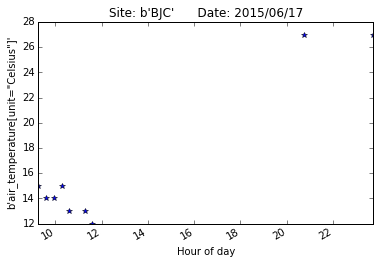

In [18]:
from matplotlib.dates import HourLocator,DateFormatter, AutoDateLocator
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(time, t_air, '*')

locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(hoursFmt)
ax1.autoscale_view()
ax1.set_title('Site: {}      Date: {}'.format(station, time[0].strftime('%Y/%m/%d')))
ax1.set_xlabel('Hour of day')
ax1.set_ylabel(t_air_label)
fig.autofmt_xdate()
plt.show()

## Now, let's request all stations within a bounding box for a given time and create a surface station plot map

In [19]:
variables = ['air_temperature', 'dew_point_temperature']
bb = {'north' : 45,
      'south' : 35,
      'east' : -100,
      'west' : -110}

querystr = pointRequest(bb = bb, startTime=dt.datetime(2015,6,17, 12), variables = variables)

url = baseurl + querystr
output = urllib.request.urlopen(url)

data = output.readlines()

tair = []
dewp = []
lons = []
lats = []
station = []
time = []
for line in data[1:]:
    vals = line.split(b",")
    #print vals
    time.append(dt.datetime.strptime(vals[0].decode('ascii'), "%Y-%m-%d %H:%M:%SZ"))
    station.append(vals[1])
    lats.append(float(vals[2]))
    lons.append(float(vals[3]))
    tair.append(float(vals[4]))
    dewp.append(float(vals[5]))
    
print(time[0],station[0],t_air[0],dewp[0])
lons = np.array(lons)
lats = np.array(lats)
tair = np.array(tair)
dewp = np.array(dewp)

2015-06-17 11:15:00 b'04V' 27.0 6.0


In [20]:
#
# This code is to facilitate station plots of the data
# Let's just skip over this
#

from matplotlib import rcParams
from matplotlib.artist import Artist
from matplotlib.cbook import is_string_like
from matplotlib.text import Text
from matplotlib.font_manager import FontProperties
class TextCollection(Artist):
    def __init__(self,
                 x=0, y=0, text='',
                 color=None,          # defaults to rc params
                 verticalalignment='bottom',
                 horizontalalignment='left',
                 multialignment=None,
                 fontproperties=None, # defaults to FontProperties()
                 rotation=None,
                 linespacing=None,
                 **kwargs
                 ):

        Artist.__init__(self)
        if color is None:
            colors= rcParams['text.color']

        if fontproperties is None:
            fontproperties = FontProperties()
        elif is_string_like(fontproperties):
            fontproperties = FontProperties(fontproperties)

        self._animated = False
#        if is_string_like(text):
#            text = [text]

        self._textobjs = [Text(x[ind], y[ind], text[ind], color,
            verticalalignment, horizontalalignment, multialignment,
            fontproperties, rotation, linespacing, **kwargs)
            for ind in range(len(x))]

        self.update(kwargs)

    def draw(self, renderer):
        for t in self._textobjs:
            t.draw(renderer)

    def set_figure(self, fig):
        for t in self._textobjs:
            t.set_figure(fig)

    def is_transform_set(self):
        return all(t.is_transform_set() for t in self._textobjs)

    def get_transform(self):
        return self._textobjs[0].get_transform()

    def set_transform(self, trans):
        for t in self._textobjs:
            t.set_transform(trans)

    def set_clip_path(self, path):
        for t in self._textobjs:
            t.set_clip_path(path)

    def set_axes(self, ax):
        for t in self._textobjs:
            t.set_axes(ax)

def text_plot(ax, x, y, data, format='%.0f', loc=None, **kw):
    from matplotlib.cbook import delete_masked_points
    from matplotlib import transforms

    # Default to centered on point
    if 'transform' in kw:
        t = kw.pop('transform')
    else:
        t = ax.projection

    if loc is not None:
        x0,y0 = loc
        trans = t._as_mpl_transform(ax) + transforms.Affine2D().translate(x0, y0)
    else:
        trans = t._as_mpl_transform(ax)

    # Handle both callables and strings for format
    if is_string_like(format):
        formatter = lambda s: format % s
    else:
        formatter = format

    # Handle masked arrays
    x,y,data = delete_masked_points(x, y, data)

    # If there is nothing left after deleting the masked points, return None
    if not data.any():
        return None

    # Make the TextCollection object
    texts = [formatter(d) for d in data]
    text_obj = TextCollection(x, y, texts, horizontalalignment='center',
        verticalalignment='center', clip_on=True, transform=trans, **kw)
#        verticalalignment='center', clip_on=True, **kw)

    # Add it to the axes
    ax.add_artist(text_obj)

    # Update plot range
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    w = maxx - minx
    h = maxy - miny

    # the pad is a little hack to deal with the fact that we don't
    # want to transform all the symbols whose scales are in points
    # to data coords to get the exact bounding box for efficiency
    # reasons.  It can be done right if this is deemed important
    padx, pady = 0.05*w, 0.05*h
    corners = (minx-padx, miny-pady), (maxx+padx, maxy+pady)
    ax.update_datalim(corners)
    ax.autoscale_view()
    return text_obj

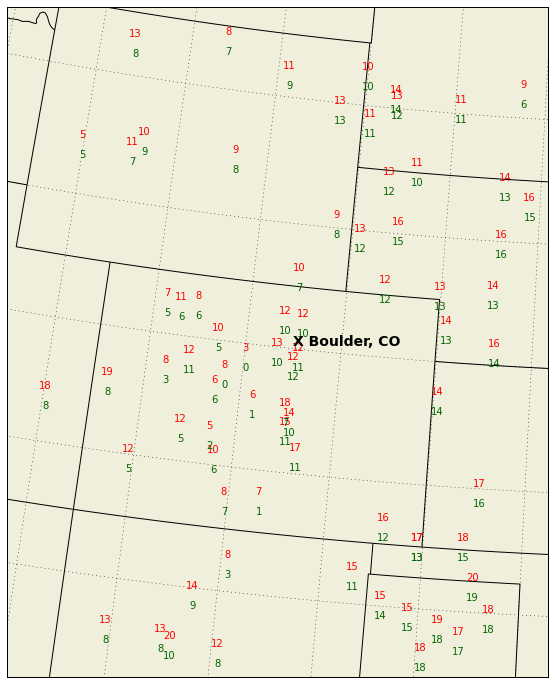

In [21]:
# Create figure
fig = plt.figure(figsize=(24,12))
proj = cartopy.crs.Stereographic(central_longitude=-95, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map features
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.NaturalEarthFeature(category='cultural', 
                                                   name='admin_1_states_provinces_lines',
                                                   scale='50m',
                                                   facecolor='none'))
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines()
ax.gridlines()

# Set extent to match requested bounding box
ax.set_extent([bb['west'], bb['east'], bb['south'], bb['north']])

# Using above helpers, plot air temperature and dewpoint as in a station plot
text_plot(ax, lons, lats, np.array(tair), transform=cartopy.crs.PlateCarree(),
          zorder=5, color='red', loc=(-10, 10))
text_plot(ax, lons, lats, np.array(dewp), transform=cartopy.crs.PlateCarree(),
          zorder=5, color='darkgreen', loc=(-10, -10))
ax.text(-105, 40, "X Boulder, CO", transform=cartopy.crs.PlateCarree(), 
        zorder=6, fontsize=14, fontweight='bold', horizontalalignment="left",
        verticalalignment="bottom")